# SGDE Tutorial

The Secure Generative Data Exchange (SGDE) is a Python application that allows users to train, upload and download generative models to and from a server.
Generative models allow the generation of synthetic data that is statistically similar to the original data, preserving individuals' privacy.
Though the SGDE Client, users can register to the SGDE API by providing a unique username, email, and password and upload their own models.
Then, they can download models from the server and use them to generate synthetic data in a user-friendly way.

The SGDE API is built on top of FastAPI and uses SQLAlchemy to manage the database. Objects are exchanged using Pydantic models.
The SGDE Client relies on TensorFlow to train generative models and on the SGDE API to upload and download them.

For more information about SGDE, please refer to the [SGDE Paper](https://arxiv.org/abs/2109.12062).

SGDE is part of the [AI-SPRINT](https://www.ai-sprint-project.eu/) project, where it provides an alternative to federated learning as a framework to train ML models on edge-stored, sensitive data.


## Imports 

In this cell, we will import the necessary libraries to load and process the client-side data.

In [1]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
np.random.seed(seed)

import logging
import tensorflow as tf
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

import random
random.seed(seed)

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.12.0


In [2]:
# Load the MNIST dataset

dataset = 'mnist'

if dataset == 'fashion_mnist':
    (X_train, y_train), (X_test, y_test) = tfk.datasets.fashion_mnist.load_data()
    X = np.concatenate([X_train, X_test],axis=0).astype('float32')
    padding = ((0, 0), (2, 2), (2, 2))
    X = np.expand_dims(np.pad(X, padding, mode='constant'),axis=-1)
    y = tfk.utils.to_categorical(np.concatenate([y_train, y_test],axis=0))
    task = 'classification'
    data_structure = 'image'
    dataset_name = 'FASHION MNIST'
    batch_size = 256
    
elif dataset == 'cifar10':
    (X_train, y_train), (X_test, y_test) = tfk.datasets.cifar10.load_data()
    X = np.concatenate([X_train, X_test],axis=0).astype('float32')
    y = tfk.utils.to_categorical(np.concatenate([y_train, y_test],axis=0))
    task = 'classification'
    data_structure = 'image'
    dataset_name = 'CIFAR10'
    batch_size = 256
    
elif dataset == 'cifar100':
    (X_train, y_train), (X_test, y_test) = tfk.datasets.cifar100.load_data()
    X = np.concatenate([X_train, X_test],axis=0).astype('float32')
    y = tfk.utils.to_categorical(np.concatenate([y_train, y_test],axis=0))
    task = 'classification'
    data_structure = 'image'
    dataset_name = 'CIFAR100'
    batch_size = 256
    
elif dataset == 'mnist':
    (X_train, y_train), (X_test, y_test) = tfk.datasets.mnist.load_data()
    X = np.concatenate([X_train, X_test],axis=0).astype('float32')
    padding = ((0, 0), (2, 2), (2, 2))
    X = np.expand_dims(np.pad(X, padding, mode='constant'),axis=-1)
    y = tfk.utils.to_categorical(np.concatenate([y_train, y_test],axis=0))
    task = 'classification'
    data_structure = 'image'
    dataset_name = 'MNIST'
    batch_size = 256
    
else:
    print("Dataset not found.")

In [3]:
# Preprocess data

temp_X = X
temp_y = y
      
temp_X = (temp_X/255).astype('float32')

callbacks = [
tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=10, min_lr=1e-5, mode='max')
]
X_train, X_test, y_train, y_test = train_test_split(temp_X, temp_y, random_state=seed, test_size=.1, stratify=np.argmax(temp_y,axis=1))

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

epochs = 200
classifier_epochs = 200

print(f'Input shape: {input_shape}')
print(f'Output shape: {output_shape}')

Input shape: (32, 32, 1)
Output shape: (10,)


## Train a new generator

In this cell, we will use the `train_generator` function to build a new data generator from MNIST data.

Metadata extraction started...
Metadata extraction completed!
Data pre-processing started...
Data pre-processing completed!
Classifier training on real data started...
247/247 - 22s - loss: 0.2069 - accuracy: 0.9342 - val_loss: 0.6801 - val_accuracy: 0.8234 - lr: 0.0010 - 22s/epoch - 88ms/step


Classifier training on real data completed!
Generator building started...
Generator building completed!
Generator training started...
EPOCH 1/1


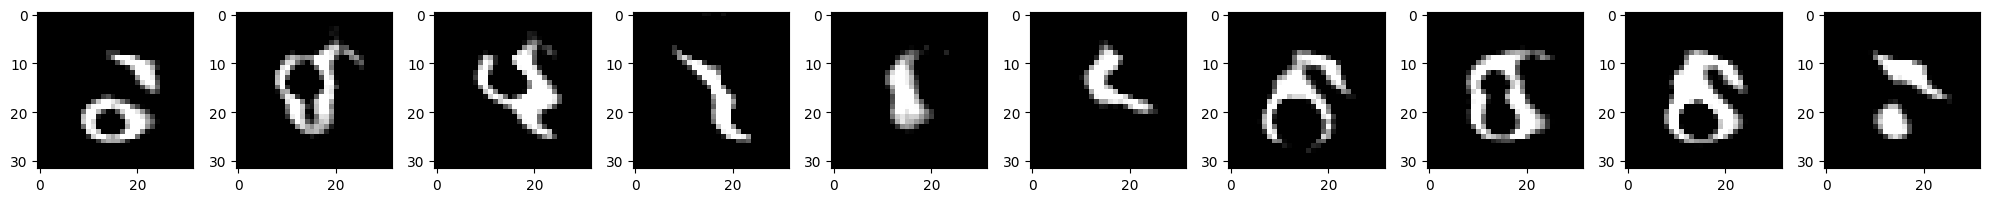

247/247 - 147s - d_loss: 0.3375 - g_loss: 2.6117 - 147s/epoch - 596ms/step
CAS: 0.1344 (Real Accuracy: 0.8234)



Generator training completed!
Best threshold computation started...
Best threshold computation completed!
Best standard deviation computation started...
Best standard deviation computation completed!


In [4]:
from sgde_client.models.training import train_generator


metadata = train_generator(
    X=X,
    y=y,
    gan_epochs=1,
    model_epochs=1,
    sleep_epochs=1,
    batch_size=batch_size,
    data_structure=data_structure,
    task=task,
    verbose=1,
    name='my_gan',
    dataset_name='MNIST'
)

## Generate data

Next, we generate some synthetic samples using the newly trained generator.

(100, 32, 32, 1)


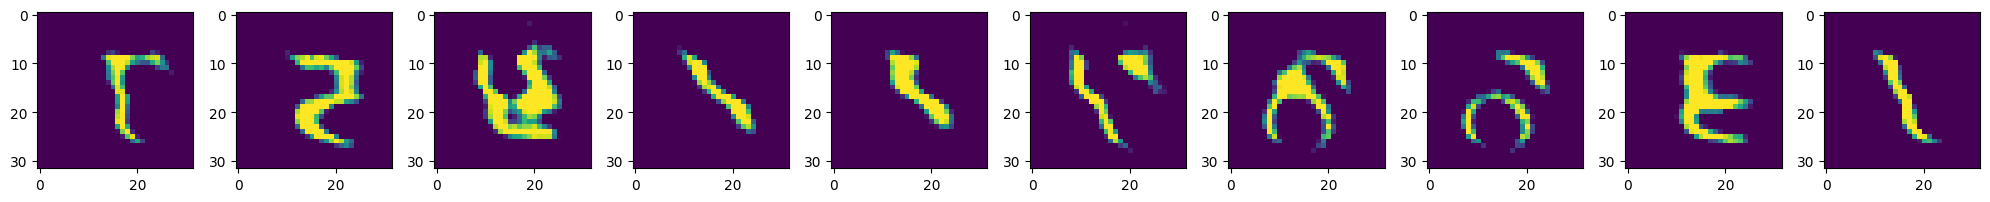

In [5]:
from sgde_client.models.inference import generate_samples_onnx

samples, labels = generate_samples_onnx(100, metadata, filter_model=False)

print(samples.shape)

fig, axes = plt.subplots(1, 10, figsize=(20,20))
for i in range(10):
    ax = axes[i%10]
    ax.imshow((np.squeeze(samples[i])+1)/2)
plt.tight_layout()
plt.show()

In [ ]:
from sgde_client.models.inference import generate_samples_onnx

samples, labels = generate_samples_onnx(5, metadata, filter_model=True)

print(samples.shape)

fig, axes = plt.subplots(1, 10, figsize=(20,20))
for i in range(10):
    ax = axes[i%10]
    ax.imshow((np.squeeze(samples[i])+1)/2)
plt.tight_layout()
plt.show()

## Interact with the SGDE API

Here, we will login to the SGDE API and exchange generator files.

In [8]:
from sgde_client.auth import register

register()

Insert username: foobar
Insert email: foobar@email.com
Insert password: ········
Confirm password: ········


[2023-10-06 21:09:40,077][INFO] Registered as foobar (foobar@email.com)
INFO:sgde_logger:Registered as foobar (foobar@email.com)


User(username='foobar', email='foobar@email.com')

In [9]:
from sgde_client.auth import login

login()

Insert username: foobar
Insert password: ········


[2023-10-06 21:09:46,821][INFO] Successfully logged in
INFO:sgde_logger:Successfully logged in


In [10]:
from sgde_client.auth import whoami

whoami()

[2023-10-06 21:09:47,736][INFO] Logged in as foobar (foobar@email.com)
INFO:sgde_logger:Logged in as foobar (foobar@email.com)


User(username='foobar', email='foobar@email.com')

In [17]:
for k, v in metadata.items():
    if type(v) == tuple:
        metadata[k] = list(metadata[k])

In [19]:
from sgde_client.exchange import upload_generator

upload_generator(metadata)

ValidationError: 1 validation error for GeneratorExtended
__root__
  Items in the list of dataset_min are not of allowed type. (type=value_error)

In [1]:
from sgde_client.exchange import get_generators

get_generators()

""


In [2]:
from sgde_client.exchange import download_generator

downloaded_metadata = download_generator("my_gan")

TypeError: download_generator() missing 1 required positional argument: 'generator_name'

In [ ]:
samples, labels = generate_samples_onnx(5, downloaded_metadata)

print(samples.shape)